> RFM 기법

- Recency : 가장 최근 상품 구입 일에서 오늘까지의 기간
- Frequency : 상품 구매 횟수, 특정 기간 동안 얼마나 자주 서비스를 이용하는지
- Monetary Value : 총 구매 금액

### **Data Set Loading & Data Cleansing**

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/Online Retail.xlsx')
retail_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


>- InvoiceNo: 주문번호 (C로 시작하는 것은 취소 주문)
- StockCode: 제품 코드
- Description: 제품 설명
- Quantity: 주문 제품 건수
- InvoiceDate: 주문 일자
- UnitPrice: 제품 단가
- CustomerID: 고객 번호
- Country: 주문 고객의 국적

In [37]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [38]:
# Null data 제거 => 고객 segmentation을 하는데, 고객 번호가 없는 data는 필요가 없기에 삭제
# 오류 data 삭제 => Quantity / Unitprice가 0보다 작은 경우
# Quantity가 0보다 작음 : 반환을 뜻함 => Invoice Num 앞자리가 'C'임 -> 분석의 효율성을 위해 삭제
# Boolean Indexing을 적용
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> **RFM 기반 데이터 가공**

In [39]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [40]:
print('총 주문 건수')
print(retail_df['CustomerID'].value_counts().head(5))
print('총 주문 금액')
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5])

총 주문 건수
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: CustomerID, dtype: int64
총 주문 금액
CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: sale_amount, dtype: float64


In [41]:
# 식별자 : 주문 번호 + 상품 코드 => unique한 identifier가 될 수 있는지 확인
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.0258946320786095

In [42]:
# 주문 번호 기준의 data를 개별 고객 기준('Customer ID')의 data로 groupby 해주어야 함

# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용 => 대상 column, aggregation 함수명을 딕셔너리 형태로 입력
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()

aggregations = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24
3,12349,2011-11-21 09:51:00,73,1757.55
4,12350,2011-02-02 16:01:00,17,334.40


In [43]:
# 이 data가 2010년 12월 1일부터 9일까지의 data이기에, 2010.12.10을 현재 날짜로 간주하고 예측을 수행
# 실제 오늘 날짜로 data를 전처리 하면 절대 안 된다
# days만 추출
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24


>### **RFM 기반 고객 Segmentation**

- 온라인 판매 data set은 소매업체의 대규모 주문을 포함하고 있다.
- 주문 횟수와 주문 금액에서 개인 고객 주문과는 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생
- **먼저 온라인 판매 data set의 칼럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는 지 알아본다.**

(array([4.303e+03, 1.800e+01, 9.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.75000000e+00, 2.80239770e+04, 5.60442040e+04, 8.40644310e+04,
        1.12084658e+05, 1.40104885e+05, 1.68125112e+05, 1.96145339e+05,
        2.24165566e+05, 2.52185793e+05, 2.80206020e+05]),
 <BarContainer object of 10 artists>)

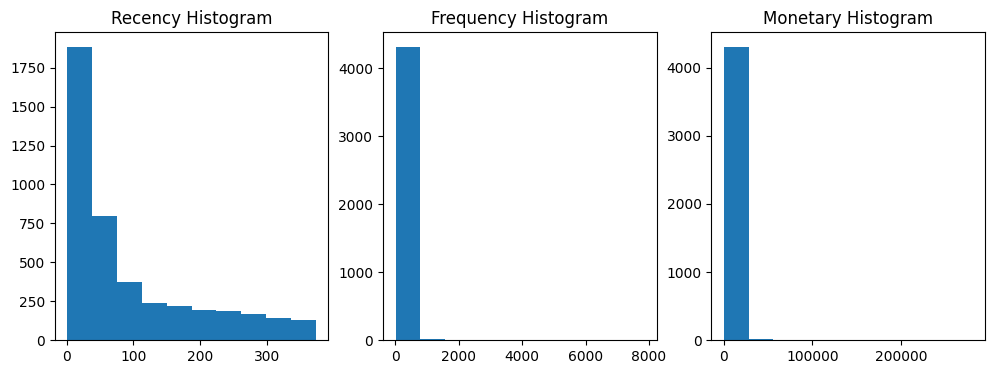

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,4), nrows = 1, ncols = 3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

=> Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심함을 알 수 있다.

In [45]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


In [46]:
# data set을 standardscaler로 평균, 표준편차를 재조정한 후, kㅡmeans 클러스터링을 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.602


=> 실루엣 계수는 0.5 이상일 때 해당 클러스터링 결과가 상당히 적절하다고 간주한다. 이 값이 1에 가까울수록 클러스터 간의 거리가 멀고 클러스터 내의 데이터 포인트가 밀집되어 있음을 나타낸다. 그러나, 실제로 군집 개수를 변화시켜보며, 군집 개수 별로 군집화 구성을 시각화 해보면

In [47]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [48]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

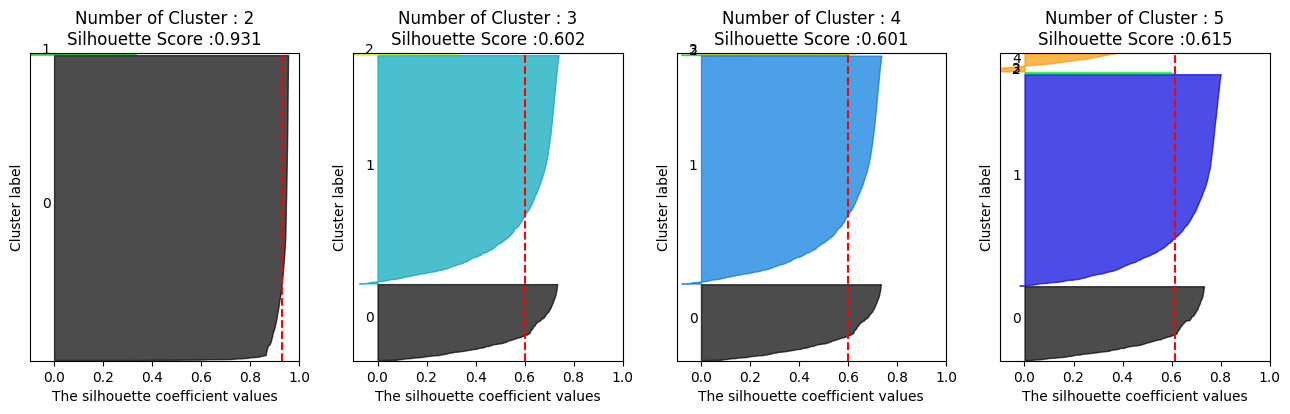

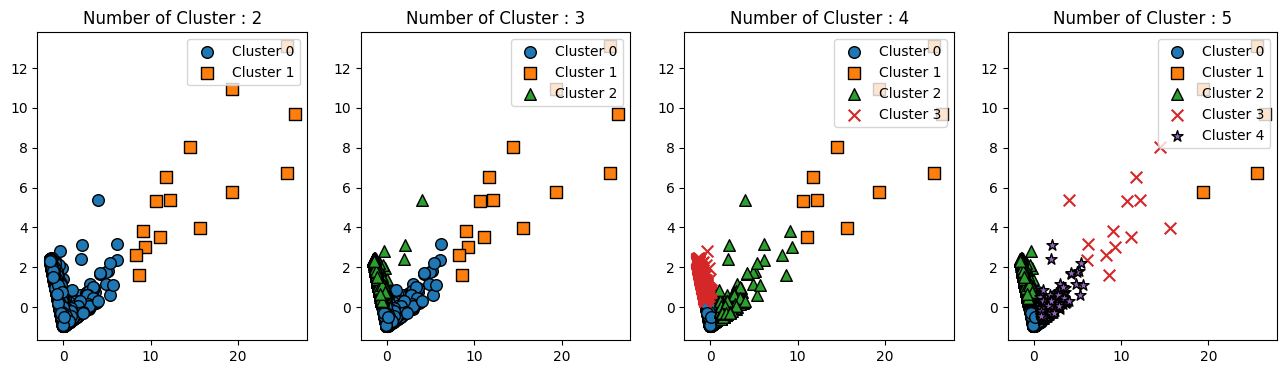

In [49]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 2개의 군집으로 군집화한 결과를 보면, 너무 개괄적으로 군집화가 되었음을 알 수 있다. 군집화가 충분히 세밀하게 이루어지지 않았거나 군집 간의 경계가 모호하여 데이터의 특성을 잘 파악하기 어렵다는 뜻이다.
- 그런데, 그렇다고 군집 수를 증가시킨다고 문제가 해결되지도 않는다. 군집이 3개 이상부터는 data set이 너무 작은 군집이 만들어진다.

> **Log 변환**

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.304


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

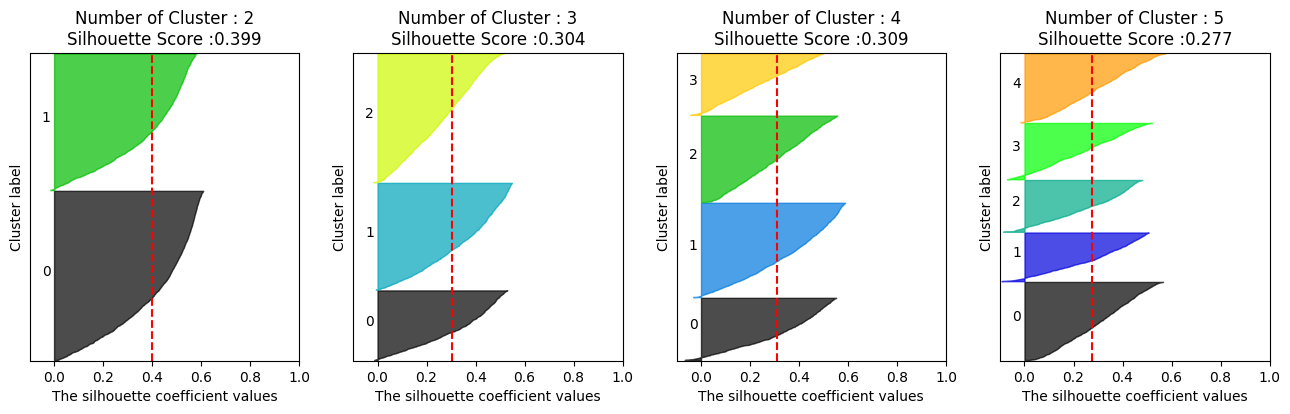

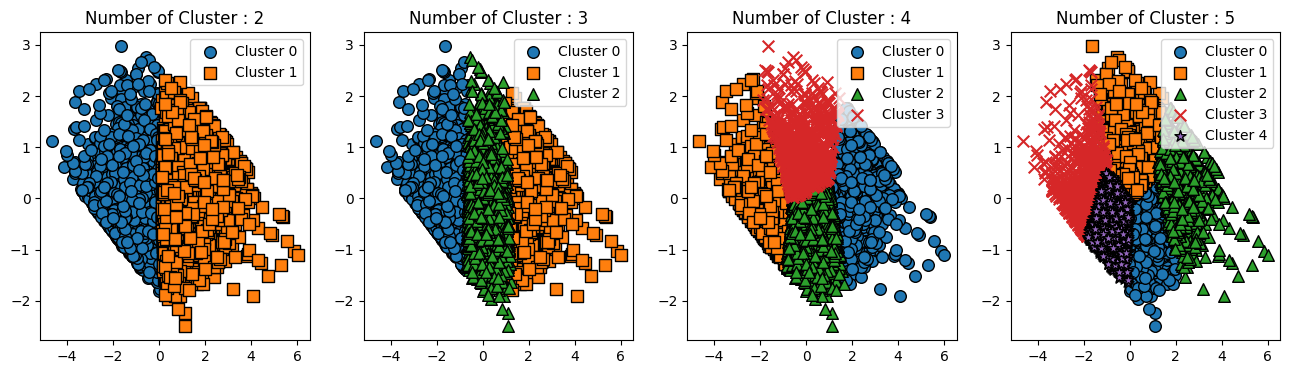

In [51]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)